### Understanding vanishing and exploding gradient problem using different activation functions
- Difference in loss function behavior when we use RelU vs Sigmoid function
- Using gradient tape to analyze gardients 

In [204]:
import numpy as np
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import utils as ut
import pandas as pd
import random

plt.rcParams['axes.grid'] = True

In [205]:
tf.random.set_seed(42) # TF
np.random.seed(42) # Numpy
random.seed(42) # Python

In [206]:
trainX, trainy, testX, testy = ut.create_dataset(n_samples=10000, centers=3, n_features=3, cluster_std=2, random_state=42)
n_input, n_classes = trainX.shape[1], testy.shape[1]

In [207]:
def evaluate_model(n_layers, trainX, trainy, testX, testy, activation):
    model = tf.keras.Sequential()
    model.add(layers.Dense(10, activation=activation, name='layer-0', input_shape=(n_input,)))
    i=0
    for i in range(n_layers):
        model.add(layers.Dense(10, activation=activation, name='layer-'+str(i+1), input_shape=(n_input,)))            
    model.add(layers.Dense(n_classes, activation='softmax', name='layer-'+str(i+2)))
        
    model.compile(optimizer='sgd', loss = 'categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(trainX, trainy, epochs=100, verbose=0)  
    loss_val, train_acc = model.evaluate(trainX, trainy, verbose=0)
    loss_val, test_acc = model.evaluate(testX, testy, verbose=0)
    
    return history, train_acc, test_acc, model

### Explation of code:

**model.compile**:
- optimizer: the algorithm used to update weights during training. e.g., adam, sgd
- a loss function: to measure the error between the predicted value and the actual value, 
    - Categorical_crossentropy: true labels are one-hot encoded
- metrics: list of metrics to be evaluated by model during testing and training
- run_eagerly: 

**model.fit**:
Returns a history object. Its History.histoyr attribute is a record of training loss values and metrics values at succesive epochs, as well as validation loss values and validation metrics values (if applicable)

**model.evaluate**
returns scalar test loss or a list of scalars 

### Sigmoid activation function

# of layers=0: 0.960
# of layers=1: 0.956
# of layers=2: 0.676
# of layers=3: 0.360


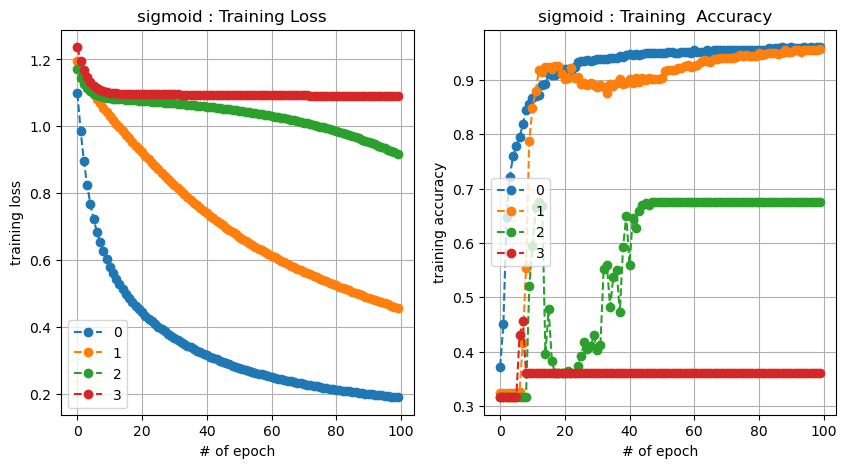

In [213]:
num_layers = [0,1,2,3]
plt.figure(figsize=(10,5))
activation = 'sigmoid'
for n_layers in num_layers:
  history, result, result_test, model = evaluate_model(n_layers, trainX, trainy, testX, testy, activation)
  #print(model.summary())
  # summarize final test set accuracy
  print('# of layers=%d: %.3f' % (n_layers, result))

  # plot learning curve 
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label=str(n_layers), marker = 'o', linestyle='--')
  plt.xlabel('# of epoch')
  plt.ylabel('training loss')
  plt.title(activation + ' : Training Loss  ')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], label=str(n_layers), marker = 'o', linestyle='--')
  plt.xlabel('# of epoch')
  plt.ylabel('training accuracy')
  plt.title(activation + ' : Training  Accuracy  ')
  plt.legend()


plt.show()

**Observation:**
- Loss function does not change/flattens for very deep layers with sigmoid function

#### Relu activation function

nodes=0: 0.962
nodes=1: 0.952
nodes=2: 0.952
nodes=3: 0.966


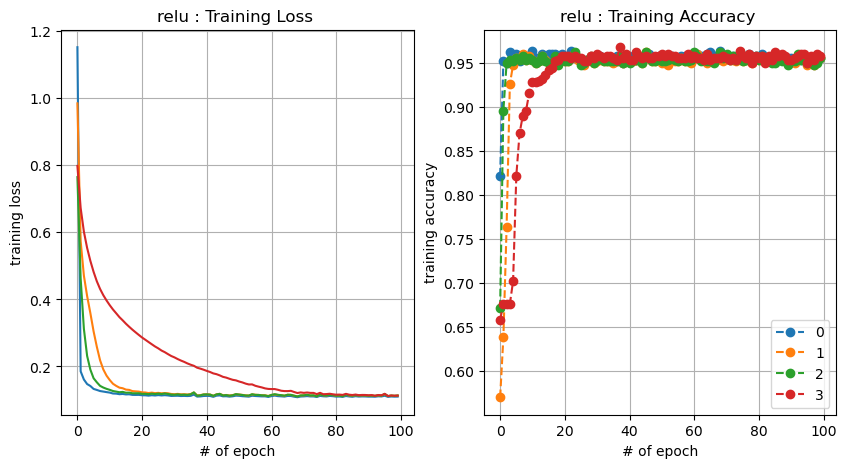

In [209]:
num_layers = [0,1,2,3]
plt.figure(figsize=(10,5))
activation = 'relu'
for n_layers in num_layers:
  history, result, result_test, model = evaluate_model(n_layers, trainX, trainy, testX, testy, activation)
  # summarize final test set accuracy
  print('nodes=%d: %.3f' % (n_layers, result))

  # plot learning curve 
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label=str(n_layers))
  plt.xlabel('# of epoch')
  plt.ylabel('training loss')
  plt.title(activation + ' : Training Loss ')
  #plt.grid()

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], label=str(n_layers), marker = 'o', linestyle='--')
  plt.xlabel('# of epoch')
  plt.ylabel('training accuracy')
  plt.title(activation + ' : Training Accuracy ')
  #plt.grid()

plt.legend()
plt.show()

### Plotting gradients during back propagation

layer-0/kernel:0, shape: (3, 10)
layer-0/bias:0, shape: (10,)
layer-1/kernel:0, shape: (10, 10)
layer-1/bias:0, shape: (10,)
layer-2/kernel:0, shape: (10, 10)
layer-2/bias:0, shape: (10,)
layer-3/kernel:0, shape: (10, 10)
layer-3/bias:0, shape: (10,)
layer-4/kernel:0, shape: (10, 10)
layer-4/bias:0, shape: (10,)
layer-5/kernel:0, shape: (10, 10)
layer-5/bias:0, shape: (10,)
layer-6/kernel:0, shape: (10, 10)
layer-6/bias:0, shape: (10,)
layer-7/kernel:0, shape: (10, 10)
layer-7/bias:0, shape: (10,)
layer-8/kernel:0, shape: (10, 10)
layer-8/bias:0, shape: (10,)
layer-9/kernel:0, shape: (10, 10)
layer-9/bias:0, shape: (10,)
layer-10/kernel:0, shape: (10, 10)
layer-10/bias:0, shape: (10,)
layer-11/kernel:0, shape: (10, 3)
layer-11/bias:0, shape: (3,)


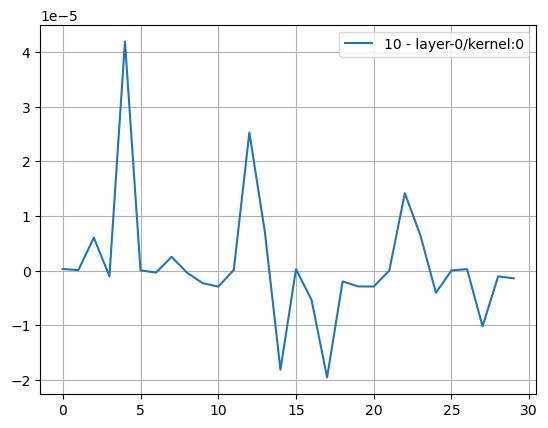

In [212]:
num_layers = [10]
#num_layers = [1]
activation = 'sigmoid'
plt.figure()
for n_layers in num_layers:
  history, result, result_test, model = evaluate_model(n_layers, trainX, trainy, testX, testy, activation)
  with tf.GradientTape() as tape:
      pred = model(trainX)
      loss = tf.keras.losses.categorical_crossentropy(trainy, pred)
      grads = tape.gradient(loss, model.trainable_variables)

  # plot weights
  for var, g in zip(model.trainable_variables, grads):
      print(f'{var.name}, shape: {g.shape}')    
      if 'layer-0/kernel' in var.name:
          plt.plot(g.numpy().flatten(), label=str(n_layers) +' - ' + str(var.name))

plt.title('Gradient of the first layer (layer-0/kernel)')     
plt.legend()
plt.show()



**Observations:**
- Sigmoid function: Gradients of weights for layer-0 goes to 1e-5 when network is deep (10 layers).
- We do not see this behavior of weights in layer 9/10
- This does not happen for relu activation function even when network is deep.